#  What is Self-Reflection in RAG?
Self-reflection = LLM evaluates its own output:
“Is this clear, complete, and accurate?”

#### Self-Reflection in RAG using LangGraph, we’ll design a workflow where the agent:

1. Generates an initial answer using retrieved context
2. Reflects on that answer with a dedicated self-critic LLM step
3. If unsatisfied, it can revise the query, retrieve again, or regenerate the answer

## Answer → Critique → Instruction → Search → Revised Answer


In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langgraph.graph import StateGraph, END

/Users/maruthienugula/RAG_learnings/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### load llm models
import os
from langchain.chat_models import init_chat_model
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=init_chat_model("groq:openai/gpt-oss-20b")

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings

# Intializing a simple Hugging face model without any api key
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

In [4]:
docs = TextLoader("research-notes.txt").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

In [6]:
from typing import Any

In [7]:
# -------------------------
# 2. State Definition
# -------------------------
class RAGReflectionState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""
    reflection: Any = ""
    feedback:str = ""
    revised: bool = False
    attempts: int = 0

In [8]:
# -------------------------
# helper: robust LLM call + JSON extractor
# -------------------------
def call_llm_return_text(prompt: str) -> str:
    """
    Try a few ways to call the llm object and return plain text.
    Adjust if your llm uses different method names in your environment.
    """
    try:
        # your environment used llm.invoke(...).content earlier
        return llm.invoke(prompt).content
    except Exception:
        try:
            # some wrappers make llm callable
            out = llm(prompt)
            # if returned object has .content or .generations, adapt:
            if isinstance(out, str):
                return out
            if hasattr(out, "content"):
                return out.content
            if hasattr(out, "generations"):
                return out.generations[0][0].text
            return str(out)
        except Exception as e:
            raise RuntimeError("Failed to call LLM: " + str(e))


In [9]:
import json

In [11]:
from typing import Dict

In [12]:
import re

In [13]:
def extract_json_from_text(text: str) -> Dict:
    """
    Find the first JSON-like block in text and return parsed dict.
    Falls back to trying to parse the whole text.
    """
    # try to find {...} block
    m = re.search(r"(\{(?:.|\s)*\})", text)
    candidate = m.group(1) if m else text
    try:
        return json.loads(candidate)
    except json.JSONDecodeError:
        # try to sanitize a bit: replace single quotes, trailing commas, etc.
        sanitized = candidate.replace("'", '"')
        sanitized = re.sub(r",\s*}", "}", sanitized)
        sanitized = re.sub(r",\s*\]", "]", sanitized)
        try:
            return json.loads(sanitized)
        except Exception:
            # as a last resort, return minimal structure
            return {"is_correct": False, "issues": "Could not parse LLM response", "suggestion": text}


In [14]:

# -------------------------
# 3. Nodes
# -------------------------

# a. Retrieve
def retrieve_docs(state: RAGReflectionState) -> RAGReflectionState:
    # include feedback in the retrieval query so retriever tries to fetch different docs
    query = state.question
    if state.feedback:
        query = f"{state.question}\n\nFocus on: {state.feedback}"
    # most retrievers expose get_relevant_documents(...)
    try:
        docs = retriever.get_relevant_documents(query)
    except Exception:
        # fallback if your retriever API is different
        docs = retriever.retrieve(query) if hasattr(retriever, "retrieve") else []
    return state.model_copy(update={"retrieved_docs": docs})

In [15]:
# b. Generate Answer
def generate_answer(state: RAGReflectionState) -> RAGReflectionState:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the following context to answer the question. If there is prior feedback, use it to improve this answer.

Context:
{context}

Question:
{state.question}

Prior feedback:
{state.feedback}

Write a concise, referenced answer.
"""
    answer = call_llm_return_text(prompt).strip()
    # increment attempt counter for each generated answer attempt
    return state.model_copy(update={"answer": answer, "attempts": state.attempts + 1})


In [16]:
# c. Self-Reflect
def reflect_on_answer(state: RAGReflectionState) -> RAGReflectionState:
    prompt = f"""
You are reviewing the provided answer critically.

Question:
{state.question}

Answer:
{state.answer}

Do the following:
1. Decide if the answer is correct and complete.
2. If NOT, list what is missing or incorrect (be specific).
3. Suggest a concrete, short instruction the generator should follow to fix it.

Respond ONLY in JSON with keys:
{{
  "is_correct": true/false,
  "issues": "short bullet or sentence",
  "suggestion": "what to do next"
}}
"""
    raw = call_llm_return_text(prompt)
    reflection = extract_json_from_text(raw)

    # revised = True if LLM says NOT correct (we want another retrieval/generation)
    revised = not bool(reflection.get("is_correct"))
    feedback = reflection.get("suggestion", "") or reflection.get("issues", "")

    return state.model_copy(update={
        "reflection": reflection,
        "revised": revised,
        "feedback": feedback,
        # do NOT increment attempts here again unless you want reflection counted separately
    })

In [17]:
# d. Finalizer
def finalize(state: RAGReflectionState) -> RAGReflectionState:
    return state

In [19]:
# -------------------------
# 4. LangGraph DAG
# -------------------------


builder = StateGraph(RAGReflectionState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)
builder.add_node("reflector", reflect_on_answer)
builder.add_node("done", finalize)

builder.set_entry_point("retriever")

builder.add_edge("retriever", "responder")
builder.add_edge("responder", "reflector")

# If reflection says revised==True -> go back to retriever (to fetch improved/other docs)
# stop when not revised OR attempts limit reached
def routing_fn(s: RAGReflectionState):
    if not s.revised:
        return "done"
    if s.attempts >= 3:  # safety cap
        return "done"
    return "retriever"

builder.add_conditional_edges("reflector", routing_fn)
builder.add_edge("done", END)
graph = builder.compile()



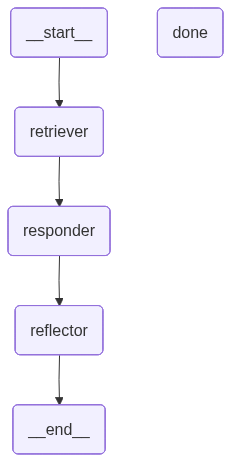

In [20]:
graph

In [21]:
# -------------------------
# 5. Run the Agent
# -------------------------
if __name__ == "__main__":
    user_query = "what are the additional experiments in Transformer evaluation?"
    init_state = RAGReflectionState(question=user_query)
    result_state = graph.invoke(init_state)

    # result_state may be a StateModel or dict depending on langgraph version
    if isinstance(result_state, dict):
        final_answer = result_state.get("answer")
        reflection = result_state.get("reflection")
        attempts = result_state.get("attempts")
    else:
        final_answer = result_state.answer
        reflection = result_state.reflection
        attempts = result_state.attempts

    print("\nFinal Answer:\n", final_answer)
    print("\nReflection Log:\n", json.dumps(reflection, indent=2))
    print("Total Attempts:", attempts)


Final Answer:
 **Additional Experiments for Evaluating Transformers**

| Category | Typical Experimental Setup | Representative Reference |
|----------|----------------------------|---------------------------|
| **1. Architectural Ablations** | 1. Remove or replace positional encoding (sinusoidal vs learned).  <br>2. Delete or mask individual attention heads or entire layers.  <br>3. Vary feed‑forward size or number of heads. | Vaswani et al., 2017 (positional encoding) <br>Kenton et al., 2020 (head removal) |
| **2. Scaling‑Law Studies** | Train models with varying depth, width, and token‑budget; plot performance vs. FLOPs or parameters.  <br>Use synthetic tasks (e.g., copying, sorting) or real corpora (Wikitext‑103, C4). | Kaplan et al., 2020 (language‑model scaling) |
| **3. Robustness & Generalization** | 1. Add Gaussian noise, token‑shuffling, or perturbations to inputs.  <br>2. Evaluate on out‑of‑distribution datasets (e.g., BLEU on new domains).  <br>3. Test adversarial attacks

In [22]:
from IPython.display import display, Markdown
display(Markdown(final_answer))

**Additional Experiments for Evaluating Transformers**

| Category | Typical Experimental Setup | Representative Reference |
|----------|----------------------------|---------------------------|
| **1. Architectural Ablations** | 1. Remove or replace positional encoding (sinusoidal vs learned).  <br>2. Delete or mask individual attention heads or entire layers.  <br>3. Vary feed‑forward size or number of heads. | Vaswani et al., 2017 (positional encoding) <br>Kenton et al., 2020 (head removal) |
| **2. Scaling‑Law Studies** | Train models with varying depth, width, and token‑budget; plot performance vs. FLOPs or parameters.  <br>Use synthetic tasks (e.g., copying, sorting) or real corpora (Wikitext‑103, C4). | Kaplan et al., 2020 (language‑model scaling) |
| **3. Robustness & Generalization** | 1. Add Gaussian noise, token‑shuffling, or perturbations to inputs.  <br>2. Evaluate on out‑of‑distribution datasets (e.g., BLEU on new domains).  <br>3. Test adversarial attacks (e.g., FGSM, PGD). | Zhang et al., 2020 (robustness to noise) <br>Carlini & Wagner, 2017 (adversarial attacks) |
| **4. Efficiency & Compression** | 1. Apply magnitude pruning or sparsification and measure accuracy drop.  <br>2. Distill a large Transformer into a smaller one.  <br>3. Measure inference latency on CPU/GPU. | Frankle & Carbin, 2019 (lottery ticket) <br>Sanh et al., 2019 (DistilBERT) |
| **5. Interpretability & Attention Analysis** | 1. Visualize attention matrices for different heads across layers.  <br>2. Correlate head importance with downstream performance via ablation. | Jain & Wallace, 2019 (attention as explanation) |
| **6. Transfer & Fine‑Tuning Dynamics** | 1. Pre‑train on a large corpus, then fine‑tune on varied downstream tasks (GLUE, SQuAD).  <br>2. Measure performance vs. number of fine‑tuning steps and learning‑rate schedules. | Devlin et al., 2019 (BERT fine‑tuning) |
| **7. Continual Learning / Lifelong Adaptation** | 1. Sequentially train on multiple tasks, measuring catastrophic forgetting.  <br>2. Use replay or regularization (e.g., EWC) to mitigate forgetting. | Lopez‑Oteriz et al., 2018 (continual learning in language) |
| **8. Latency & Energy Profiling** | 1. Profile GPU/CPU memory usage and FLOPs per token.  <br>2. Measure energy consumption on a target device (e.g., mobile). | Ruder et al., 2021 (energy‑efficient Transformers) |

### How to Run These Experiments

1. **Baseline Setup** – Train a standard Transformer (e.g., BERT‑base) on a chosen corpus.
2. **Controlled Variations** – Apply one modification at a time (e.g., remove a head) to isolate its effect.
3. **Metrics** – Use task‑specific accuracy, perplexity, BLEU, or AUC, plus auxiliary metrics (FLOPs, latency, energy).
4. **Statistical Significance** – Run multiple seeds and report mean ± std.

### Key Take‑aways

- Ablation and scaling studies expose which architectural components are critical.  
- Robustness experiments reveal how well a model generalizes to noisy or unseen data.  
- Efficiency tests guide deployment decisions for resource‑constrained settings.  
- Interpretability and transfer studies help understand *why* a Transformer works and how it can be reused.  

These experiments complement the usual benchmark evaluations and provide a deeper, more actionable understanding of Transformer behavior.